In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.6 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from transformers import TFBertModel, BertTokenizer
seed_value = 29
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
np.set_printoptions(precision=2)
import tensorflow as tf
tf.random.set_seed(seed_value)
import tensorflow_addons as tfa
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import ModelCheckpoint
import re
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
N_AXIS = 4
MAX_SEQ_LEN = 128
BERT_NAME = 'bert-base-uncased'
'''
EMOTIONAL AXES:
Introversion (I) – Extroversion (E)
Intuition (N) – Sensing (S)
Thinking (T) – Feeling (F)
Judging (J) – Perceiving (P)
'''
axes = ["I-E","N-S","T-F","J-P"]
classes = {"I":0, "E":1, # axis 1
           "N":0,"S":1, # axis 2
           "T":0, "F":1, # axis 3
           "J":0,"P":1} # axis 4

In [ ]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub('', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text.encode('ascii', 'ignore').decode('ascii')
    if text.startswith("'"):
        text = text[1:-1]
    return text

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving MBTI 500.csv to MBTI 500 (1).csv


In [ ]:
import pandas as pd
import re
import numpy as np
train_n=6624
val_n=1024
test_n=1024
data = pd.read_csv("MBTI 500.csv")
data = data.sample(frac=1)
labels = []
print(data)
for personality in data["type"]:
    pers_vect = []
    for p in personality:
        pers_vect.append(classes[p])
    labels.append(pers_vect)
sentences = data["posts"].apply(str).apply(lambda x: text_preprocessing(x))
labels = np.array(labels, dtype="float32")
train_sentences = sentences[:train_n]
y_train = labels[:train_n]
val_sentences = sentences[train_n:train_n+val_n]
y_val = labels[train_n:train_n+val_n]
test_sentences = sentences[train_n+val_n:train_n+val_n+test_n]
y_test = labels[train_n+val_n:train_n+val_n+test_n]
     

                                                    posts  type
63953   sama heah benefit etc yang di indo nggak ada t...  ENTJ
95897   person ever someone strong enough good enough ...  INFP
91910   work even people see year kind like rainman ab...  INFJ
80358   wrong country pay attention infp really enfp w...  INFJ
75835   busy destroy one ever focus real enemy consist...  ENTP
...                                                   ...   ...
60962   thing list everything appreciate use others em...  ENFP
10749   thing step seem illogical learn topic learn in...  INTJ
104684  little moment last night lot frustration life ...  INFP
97651   tragedy sleeve share sparingly casual context ...  INFP
90069   plenty advice find look fwiw istp operate manu...  INFJ

[106067 rows x 2 columns]


In [ ]:
def prepare_bert_input(sentences, seq_len, bert_name):
    tokenizer = BertTokenizer.from_pretrained(bert_name)
    encodings = tokenizer(sentences.tolist(), truncation=True, padding='max_length',
                                max_length=seq_len)
    input = [np.array(encodings["input_ids"]), np.array(encodings["token_type_ids"]),
               np.array(encodings["attention_mask"])]
    return input

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertTokenizer
X_train = prepare_bert_input(train_sentences, MAX_SEQ_LEN, BERT_NAME)
X_val = prepare_bert_input(val_sentences, MAX_SEQ_LEN, BERT_NAME)
X_test = prepare_bert_input(test_sentences, MAX_SEQ_LEN, BERT_NAME)

In [ ]:
from transformers import TFBertModel
import keras
from tensorflow.keras import layers 
input_ids = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_ids')
input_type = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='token_type_ids')
input_mask = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='attention_mask')
inputs = [input_ids, input_type, input_mask]
bert = TFBertModel.from_pretrained(BERT_NAME)
bert_outputs = bert(inputs)
last_hidden_states = bert_outputs.last_hidden_state
avg = layers.GlobalAveragePooling1D()(last_hidden_states)
output = layers.Dense(N_AXIS, activation="sigmoid")(avg)
model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'token_type_ids[0][0]',     

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
from keras.callbacks import ModelCheckpoint
max_epochs = 7
batch_size = 32
opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
loss = keras.losses.BinaryCrossentropy()
best_weights_file = "weights.h5"
auc = keras.metrics.AUC(multi_label=True, curve="ROC")
m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_'+auc.name, mode='max', verbose=2,
                          save_weights_only=True, save_best_only=True)
model.compile(loss=loss, optimizer=opt, metrics=[auc, keras.metrics.BinaryAccuracy()])
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    batch_size=batch_size,
    callbacks=[m_ckpt],
    verbose=2
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Epoch 1/7



Epoch 1: val_auc improved from -inf to 0.76766, saving model to weights.h5
207/207 - 201s - loss: 0.5328 - auc: 0.6212 - binary_accuracy: 0.7261 - val_loss: 0.4544 - val_auc: 0.7677 - val_binary_accuracy: 0.7886 - 201s/epoch - 972ms/step
Epoch 2/7

Epoch 2: val_auc improved from 0.76766 to 0.78861, saving model to weights.h5
207/207 - 181s - loss: 0.4333 - auc: 0.7960 - binary_accuracy: 0.8037 - val_loss: 0.4397 - val_auc: 0.7886 - val_binary_accuracy: 0.7908 - 181s/epoch - 874ms/step
Epoch 3/7

Epoch 3: val_auc improved from 0.78861 to 0.80310, saving model to weights.h5
207/207 - 181s - loss: 0.4062 - auc: 0.8271 - binary_accuracy: 0.8176 - val_loss: 0.4221 - val_auc: 0.8031 - val_binary_accuracy: 0.8010 - 181s/epoch - 873ms/step
Epoch 4/7

Epoch 4: val_auc did not improve from 0.80310
207/207 - 177s - loss: 0.3675 - auc: 0.8647 - binary_accuracy: 0.8359 - val_loss: 0.4311 - val_auc: 0.7986 - val_binary_accuracy: 0.7952 - 177s/epoch - 855ms/step
Epoch 5/7

Epoch 5: val_auc did not i

In [ ]:
loss = keras.losses.BinaryCrossentropy()
best_weights_file = "weights.h5"
model.load_weights(best_weights_file)
opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
model.compile(loss=loss, optimizer=opt, metrics=[keras.metrics.AUC(multi_label=True, curve="ROC"),
                                                  keras.metrics.BinaryAccuracy()])
predictions = model.predict(X_test)
model.evaluate(X_test, y_test, batch_size=32)
     

32/32 [==============================] - 11s 262ms/step - loss: 0.4172 - auc_1: 0.8110 - binary_accuracy: 0.8127


[0.4171658158302307, 0.8109892010688782, 0.812744140625]

In [ ]:
def plot_roc_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc))
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
     

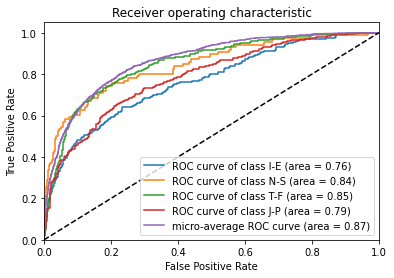

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
plot_roc_auc(y_test, predictions, axes)
     

In [ ]:
s1 =  "Their movies have many vulgar songs and scenes. They do not go with our social culture. We present a more clean and family oriented source to our audience. We try to give moral lessons to our audience in the form of entertainment I did two lab courses (CSE225L & CSE231L) under him. When I got him as a lab instructor for the second time, I tried to change sec but then I didn't because the faculty was really good. Now I know that was a mistake."
sentences = np.asarray([s1])
enc_sentences = prepare_bert_input(sentences, MAX_SEQ_LEN, BERT_NAME)
predictions = model.predict(enc_sentences)
for sentence, pred in zip(sentences, predictions):
    pred_axis = []
    mask = (pred > 0.5).astype(bool)
    for i in range(len(mask)):
        if mask[i]:
            pred_axis.append(axes[i][2])
        else:
            pred_axis.append(axes[i][0])
    print('-- comment: '+sentence.replace("\n", "").strip() +
          '\n-- personality: '+str(pred_axis) +
          '\n-- scores:'+str(pred))

1/1 [==============================] - 0s 84ms/step
-- comment: Their movies have many vulgar songs and scenes. They do not go with our social culture. We present a more clean and family oriented source to our audience. We try to give moral lessons to our audience in the form of entertainment I did two lab courses (CSE225L & CSE231L) under him. When I got him as a lab instructor for the second time, I tried to change sec but then I didn't because the faculty was really good. Now I know that was a mistake.
-- personality: ['I', 'N', 'T', 'J']
-- scores:[0.22 0.16 0.45 0.49]


In [ ]:
tf.keras.Model.save

<function keras.engine.training.Model.save(self, filepath, overwrite=True, include_optimizer=True, save_format=None, signatures=None, options=None, save_traces=True)>